In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/PDE'

Mounted at /content/drive
/content/drive/MyDrive/PDE


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from utils_ver2 import *


import matplotlib.pyplot as plt

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
%reload_ext autoreload
%autoreload 2
from utils_ver2 import *

# Sampling points

### input example (for 2D Burgers' equation)
PDE Dimension(excluding t) : 2\
Number of collocation points : 20000\
x_min : 0\
x_max : 0.5\
test_x_grid_num : 50\
y_min : 0\
y_max : 0.5\
test_y_grid_num : 50\
t_max : 1\
test_t_grid_num : 11\
Number of boundary conditions: 0\
boundary/initial points rato (%) : 10

PDE Dimension(excluding t) : 2
Number of collocation points : 20000
x_min : 0
x_max : 1
test_x_grid_num : 50
y_min : 0
y_max : 1
test_y_grid_num : 50
t_max : 1
test_t_grid_num : 11
Number of boundary conditions: 0
boundary/initial points rato (%) : 10
Total sampled points : 22000


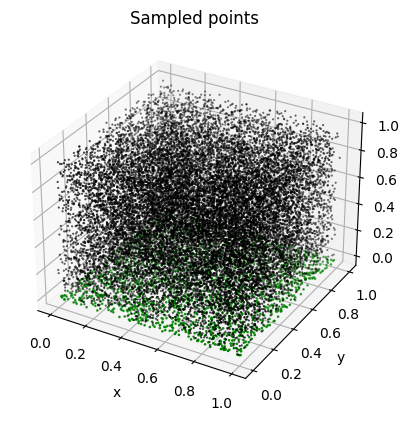

In [4]:
# This will sample the points needed to train
# Refer to above statement and sample the points needed to predict 2D Burgers' equation
points_dict, test_dict = point_sampler()

# Define dataset and network

In [5]:
class PINN(nn.Module):
  def __init__(self, input_dim =  int, output_dim = int):
    super(PINN,self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.layers = nn.Sequential(
        nn.Linear(self.input_dim,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,self.output_dim)

    )

  def forward(self,x_y_t):
    return self.layers(x_y_t)

# Define PDE conditions

In [6]:
# This is for setting initial conditions and boundary conditions if analytical solution exists
# For the case of 2D Burgers' equation, analytical solution can be driven if initial condition is linear combination of x and y
# class Linear_condition is for convenience
class Linear_condition():
  def __init__(self,coef):
    self.a = coef[0]
    self.b = coef[1]
    self.c = coef[2]
    self.d = coef[3]
    self.D = self.a*self.d - self.b*self.c
  def analytic_solution(self,batch):
    x = batch[:,0]
    y = batch[:,1]
    t = batch[:,2]

    denominator = self.D*(t**2) + (self.a+self.d)*t + 1

    u = (((self.D * t + self.a)*x + self.b * y)/denominator).unsqueeze(dim=-1)
    v = (((self.D * t + self.d)*y + self.c * x)/denominator).unsqueeze(dim=-1)

    result = torch.cat((u,v), dim=-1)

    return result
  def initial_condition(self,initial_points):
    return self.analytic_solution(initial_points)

  def boundary_condition(self,boundary_points):
    return self.analytic_solution(boundary_points)


# Here is for another analytical solution type
class Known_condition():
  def __init__(self,nu):
    self.nu = nu

  def analytic_solution(self,batch):
    x = batch[:,0].unsqueeze(dim = -1)
    y = batch[:,1].unsqueeze(dim = -1)
    t = batch[:,2].unsqueeze(dim = -1)

    exp_term = torch.exp((-4*x+4*y-t)*(1/self.nu)/32)
    u = 3/4-1/(4*(1+exp_term))
    v = 3/4 + 1/(4*(1+exp_term))

    result = torch.cat((u,v), dim=-1)

    return result

  def initial_condition(self,initial_points):
    return self.analytic_solution(initial_points)

  def boundary_condition(self,boundary_points):
    return self.analytic_solution(boundary_points)



# This is for setting initial and boundary conditions by user input.
# Can be used if there is no analytical solution
class Unknown_condition():

  def initial_condition(self,initial_points):
    x = initial_points[:,0].unsqueeze(dim = -1)
    y = initial_points[:,1].unsqueeze(dim = -1)
    t = initial_points[:,2].unsqueeze(dim = -1)

    initial_condition1 = None
    initial_condition2 = None

    return torch.cat((initial_condition1, initial_condition2), dim = -1)

  def boundary_condtion1(self,boundary_points):
    x = None
    y = None
    t = None

    boundary_condition1 = None
    boundary_condition2 = None

    return torch.cat((boundary_condition1, boundary_condition2), dim = -1)

In [7]:
# Initiate initial condition
condition = Linear_condition(coef = [1.,-3.,1.,-2.])

# Define loss function and RAR method

In [8]:
def loss_fn(batch, model, points_dict, condition, device, boundary_condition = None, loss_ratio = None):

  # Forward
  batch = batch.requires_grad_(True).to(device)
  initial_points = points_dict['initial'].to(device)

  # Get output of batch and initial points
  pde_out = model(batch)
  initial_out = model(initial_points)

  # Loss metric
  mse = nn.MSELoss().to(device)

  # First order partial derivative
  du = torch.autograd.grad(outputs = pde_out[:,0], inputs = batch, grad_outputs=torch.ones_like(pde_out[:,0]), create_graph = True)
  dv = torch.autograd.grad(outputs = pde_out[:,1], inputs = batch, grad_outputs=torch.ones_like(pde_out[:,1]), create_graph = True)

  u_x = du[0][:,0]
  u_y = du[0][:,1]
  u_t = du[0][:,2]

  v_x = dv[0][:,0]
  v_y = dv[0][:,1]
  v_t = dv[0][:,2]

  # Second order partial derivative
  u_xx = torch.autograd.grad(outputs = du[0][:,0], inputs = batch, grad_outputs = torch.ones_like(du[0][:,0]), create_graph = True)[0][:,0]
  u_yy = torch.autograd.grad(outputs = du[0][:,1], inputs = batch, grad_outputs = torch.ones_like(du[0][:,1]), create_graph = True)[0][:,1]

  v_xx = torch.autograd.grad(outputs = dv[0][:,0], inputs = batch, grad_outputs = torch.ones_like(dv[0][:,0]), create_graph = True)[0][:,0]
  v_yy = torch.autograd.grad(outputs = dv[0][:,1], inputs = batch, grad_outputs = torch.ones_like(dv[0][:,1]), create_graph = True)[0][:,1]


  # PDE loss
  # Rearrange PDE to be like PDE = 0
  # Below is form of 2D Burgers' equation
  nu = 0
  pde_u = u_t+pde_out[:,0]*u_x + pde_out[:,1]*u_y -nu*(u_xx+u_yy)
  pde_v = v_t + pde_out[:,0]*v_x + pde_out[:,1]*v_y- nu*(v_xx+v_yy)
  pde_loss = mse(pde_u, torch.zeros_like(pde_u)) + mse(pde_v, torch.zeros_like(pde_v))

  pde_loss_tensor = pde_u**2 + pde_v**2 # This is for RAR criteria

  # Initial condition loss
  initial_condition = condition.initial_condition(initial_points).to(device)
  initial_loss = mse(initial_out, initial_condition)

  # Sum all losses
  total_loss = pde_loss + initial_loss

  return pde_loss, initial_loss, pde_loss_tensor, total_loss


In [16]:
def RAR(epoch_cnt,model,pde_loss, device):
    # Collocation datapoints
    num = 20000//(2**(epoch_cnt//100)) # Decreasing sampling points over epochs
    col_x_acce = torch.linspace(0, 1, num)[torch.randperm(num)].unsqueeze(dim = -1)
    col_y_acce = torch.linspace(0, 1, num)[torch.randperm(num)].unsqueeze(dim = -1)
    col_t_acce = torch.linspace(0, 1, num)[torch.randperm(num)].unsqueeze(dim = -1)

    col_acce = torch.cat((col_x_acce, col_y_acce, col_t_acce), dim = -1).requires_grad_(True).to(device)

    # PDE loss for new datapoints
    _,_,pde_loss_acce,_ = loss_fn(col_acce, model, points_dict, condition, device)

    # Sample datapoints which pde loss is larger than given pde_loss
    criteria = pde_loss_acce - pde_loss
    sampled_col_points = col_acce[criteria > 0].detach()

    return sampled_col_points

In [17]:
# Closure function to use LBFGS
def closure():
  _,_,_,loss = loss_fn(batch, model, points_dict, condition, device)
  optimizer.zero_grad()
  loss.backward()
  if epoch_cnt % 100 == 0:
    print(f'LOSS {loss}')
  return loss

# Train

In [22]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = PINN(input_dim = 3, output_dim = 2).to(device)

num_epochs = 1000

optimizer = optim.LBFGS(model.parameters())
col_x_y_t = points_dict['collocation']

print(f'CURRENT_DEVICE : {device}')

CURRENT_DEVICE : cuda:0


In [23]:
for epoch_cnt in range(1,num_epochs):
  # Epoch starting 1 is because RAR must be executed after main train loop is executed at least once
  if epoch_cnt % 100 == 0:

    print(f'EPOCH {epoch_cnt}')

    # Execute RAR every 100 epoch step
    pde_out = model(batch).detach()
    pde_loss,_,_,_ = loss_fn(batch, model, points_dict, condition, device)
    sampled_col_points = RAR(epoch_cnt, model, pde_loss, device).to(device)

    # Add new points from RAR
    col_x_y_t = torch.cat((col_x_y_t.to(device), sampled_col_points), dim = 0)

    print(f'NEW_POINTS : {sampled_col_points.shape[0]}')

  # Main train loop
  batch = col_x_y_t.to(device).requires_grad_(True)
  optimizer.step(closure)

  if epoch_cnt % 200 == 0:
    # Validate the model and save the network
    validate_visualization(model, device, condition , observe_t = [0.0,0.2,0.4,0.6,0.8,1.0], x_range = [0.0,1.0], y_range = [0.0,1.0], axis_range_ratio = 1.1)
    torch.save(model, f'./pt/2D_BURGERS_LBFGS_LINEAR_EPOCH{epoch_cnt}.pt')

torch.save(model,'./pt/2D_BURGERS_LBFGS_LINEAR_EPOCH_LAST.pt')
validate_visualization(model, device, condition, observe_t = [0.0,0.2,0.4,0.6,0.8,1.0], x_range = [0.0,1.0], y_range = [0.0,1.0], axis_range_ratio = 1.1)

Output hidden; open in https://colab.research.google.com to view.

# Test

In [26]:
# Input the point and get result of u and v (2D Burgers' equation)
test_x_y_t = torch.tensor(list(map(float, input('x,y,t : ').split(',')))).unsqueeze(dim = 0)

model = torch.load('./pt/2D_BURGERS_LBFGS_LINEAR_EPOCH_LAST.pt', map_location = 'cpu')
output = model(test_x_y_t).detach()
exact = condition.analytic_solution(test_x_y_t)
print(f'PREDICTED : {output}')
print(f'ANALYTICAL : {exact}')

x,y,t : 0.5,0.5,0.7
PREDICTED : tensor([[-0.8359, -0.1996]])
ANALYTICAL : tensor([[-0.8228, -0.1899]])


In [28]:
model = model.to(device)
total_error = real_test(test_dict, model, 1, loss_fn, condition, device)

tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.3069e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


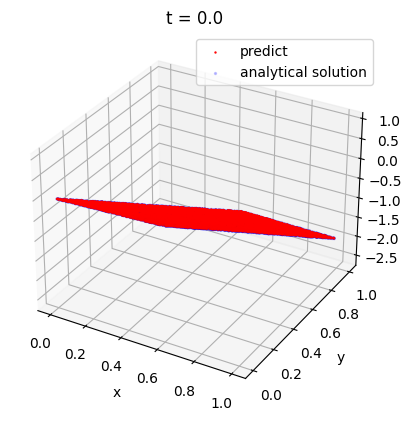

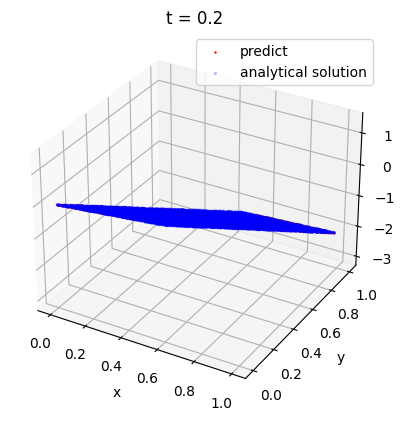

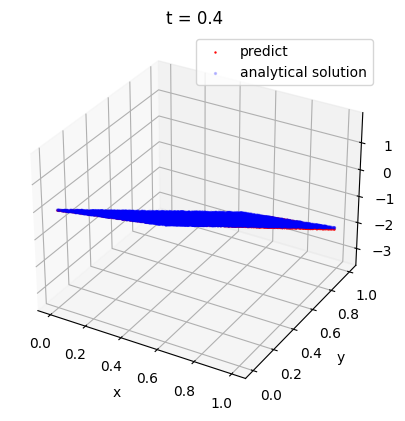

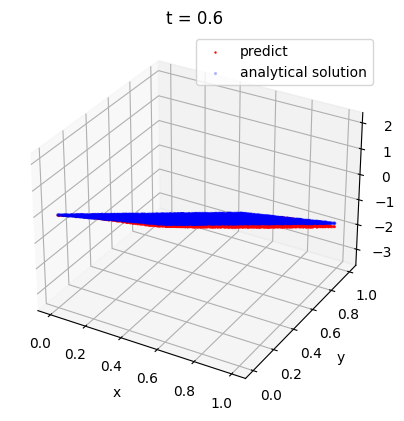

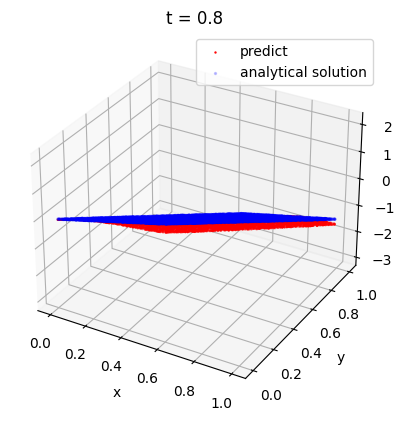

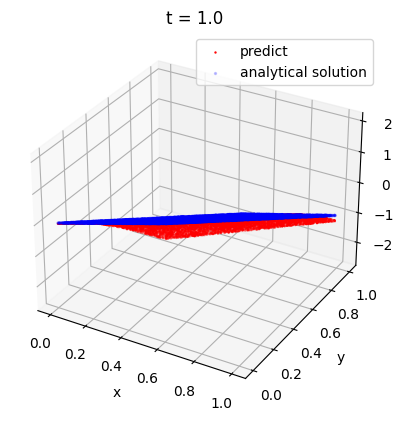

In [29]:
validate_visualization(model, device, condition, observe_t = [0.0,0.2,0.4,0.6,0.8,1.0], x_range = [0.0,1.0], y_range = [0.0,1.0], axis_range_ratio = 1.1)